# Recurrent Neural Network with Tensorflow API

## Creating and Plotting the data

Give the model a series = [0, 0.84, 0.91, 0.14, -0.75, -0.96, -0.28] and see what the next is

Actually it is Sin(x)

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Create a Class that will be able to create the data and also generate batches 
# to send back

class TimeSeriesData():
    
    def __init__(self, num_points, xmin, xmax):
        
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        
        self.resolution = (self.xmax - self.xmin)/self.num_points
        # Defining x for num_points points
        self.x_data = np.linspace(start = self.xmin,
                                  stop = self.xmax,
                                  num = self.num_points)
        # Getting the Sin(x) for all of the x_data points
        self.y_true = np.sin(self.x_data)
    
    # Returns the sin of an input array
    def ret_true(self, x_series):
        return np.sin(x_series)
    
    
    def next_batch(self, batch_size, steps, return_batch_time_series=False):
        
        # Grab a random starting point for each batch
        rand_start =np.random.rand(batch_size, 1)
        
        # Convert the random start to be lying somewhere on the time series
        time_series_start = rand_start * (self.xmax - self.xmin - (steps*self.resolution))
        
        # Create a batch time series on the x-axis
        batch_time_series = time_series_start + np.arange(0.0, steps+1) * self.resolution
        
        # Create a corresponding y_data for each of the x_data points
        y_batch = np.sin(batch_time_series)
        
        # Format the whole thing for RNN
        if return_batch_time_series:
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1), batch_time_series
        else:
            # first batch represents the time series, second batch reprersents the 
            # series shifted over by one step into the future so we can train
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1)
        

In [3]:
# Creating Data
ts_data = TimeSeriesData(num_points=250, xmin=0, xmax=10)

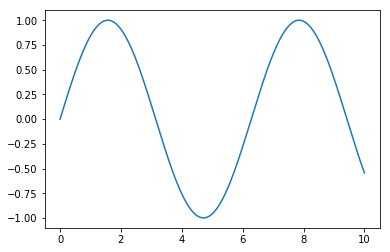

In [5]:
# Plotting the data
plt.plot(ts_data.x_data, ts_data.y_true);

In [6]:
# Each of my random batches should have 30 steps in it
num_time_steps = 30

In [7]:
# I need 1 batch of 30 time steps with the batch time series
y1, y2, ts = ts_data.next_batch(batch_size=1, steps=num_time_steps, return_batch_time_series=True)

In [8]:
ts

array([[0.68880336, 0.72880336, 0.76880336, 0.80880336, 0.84880336,
        0.88880336, 0.92880336, 0.96880336, 1.00880336, 1.04880336,
        1.08880336, 1.12880336, 1.16880336, 1.20880336, 1.24880336,
        1.28880336, 1.32880336, 1.36880336, 1.40880336, 1.44880336,
        1.48880336, 1.52880336, 1.56880336, 1.60880336, 1.64880336,
        1.68880336, 1.72880336, 1.76880336, 1.80880336, 1.84880336,
        1.88880336]])

In [9]:
ts.shape

(1, 31)

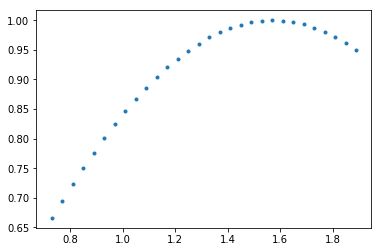

In [10]:
# Plotting
plt.plot(ts.flatten()[1:], y2.flatten(), '.')

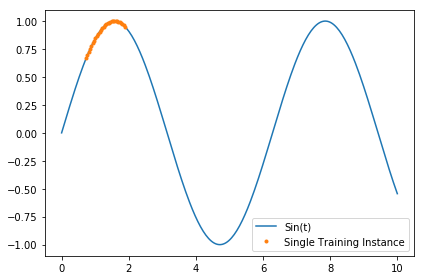

In [11]:
# Original Sine wave
plt.plot(ts_data.x_data, ts_data.y_true, label='Sin(t)')
plt.plot(ts.flatten()[1:], y2.flatten(), '.', label='Single Training Instance')
plt.legend()
plt.tight_layout() # automatic padding for legibility

In [12]:
# Training Data

train_inst = np.linspace(5, 5 + ts_data.resolution*(num_time_steps+1), num_time_steps+1)
train_inst

array([5.        , 5.04133333, 5.08266667, 5.124     , 5.16533333,
       5.20666667, 5.248     , 5.28933333, 5.33066667, 5.372     ,
       5.41333333, 5.45466667, 5.496     , 5.53733333, 5.57866667,
       5.62      , 5.66133333, 5.70266667, 5.744     , 5.78533333,
       5.82666667, 5.868     , 5.90933333, 5.95066667, 5.992     ,
       6.03333333, 6.07466667, 6.116     , 6.15733333, 6.19866667,
       6.24      ])

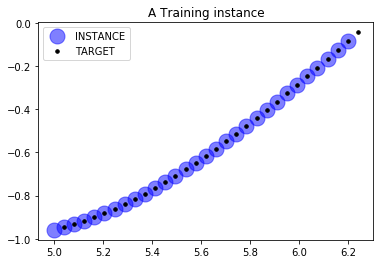

In [13]:
plt.title("A Training instance")
plt.plot(train_inst[:-1], ts_data.ret_true(train_inst[:-1]), 'bo', markersize=15, alpha=0.5, 
        label='INSTANCE');
# We need to predict exactly one time step forward
plt.plot(train_inst[1:],ts_data.ret_true(train_inst[1:]), 'k.', markersize=7, label='TARGET')
plt.legend();

Now this graph is interpreted as - Given the blue points, can you generate the black points?

## Creating the Model

In [13]:
# Uncomment below line if using GPUs
# tf.reset_default_graph() # Obligatory

In [14]:
# DESIGNING THE NETWORK OUTLINE
num_inputs = 1 # We only have one feature ie the value of x
num_neurons = 100
num_outputs = 1
learning_rate = 0.001
num_training_iterations = 2000
batch_size = 1

# PLACEHOLDERS
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

# RNN CELL LAYER
cell = tf.contrib.rnn.BasicRNNCell(num_units=num_neurons,
                                  activation=tf.nn.relu)
# We just need 1 time series output, we are using 100 neurons, but we dont need 100 outputs
# So we use an output projection wrapper (Check docstring again for more details)
cell = tf.contrib.rnn.OutputProjectionWrapper(cell, output_size=num_outputs)
# Creating a Recurrent NeuralNet specified by the cell (has to be RNN Cell)
# Note: this is deprecated, will need to run keras.layers.RNN(cell) which is equivalent
outputs, states = tf.nn.dynamic_rnn(cell=cell, inputs=X, dtype=tf.float32)

# LOSS FUNCTION:
# Using Mean Squared Error: between outputs and the placeholder y of true labels
loss = tf.reduce_mean(tf.square(outputs-y))

# OPTIMIZER and TRAINING OBJECT
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.9, beta2=0.999,
                                  epsilon=1e-08)
# Note: SGD with Nesterov and simple annealing with eta=0.001 also works
train = optimizer.minimize(loss)

# CREATING GLOBAL VARIBALE INITIALIZER OBJECT FOR THE VARIBALES
init = tf.global_variables_initializer()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.


## Running the Session

In [16]:
# SESSION

# Note: Uncomment below line if using GPUs
# To limit the memory usage of GPU
# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.75)

# Saver function to save my model to use later
saver = tf.train.Saver()

In [15]:
# Uncomment this Session() mainloop if using GPUs
# with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
with tf.Session() as sess:
    # Initialize the Variables
    sess.run(init)
    
    for iteration in range(num_training_iterations):
        # Get the next batch
        X_batch, y_batch = ts_data.next_batch(batch_size=batch_size, steps=num_time_steps)
        # Running the session with the current batch
        # On the train object designed to minimize the MSE with AdamOptimization
        sess.run(train, feed_dict={
            X: X_batch,
            y: y_batch
        })
        # Calculating the accuracy every 100 steps and report back
        if iteration%10 == 0:
            # Calculating the loss on the training set
            mse = loss.eval(feed_dict={
                X: X_batch,
                y: y_batch
            })
            print(iteration, "\tMSE: ", mse)
    saver.save(sess, "./TF_RNN_Adam_NoGPU_NoLSTMCell")

0 	MSE:  0.18703057
10 	MSE:  0.047972705
20 	MSE:  0.03178356
30 	MSE:  0.09158231
40 	MSE:  0.020529598
50 	MSE:  0.01538178
60 	MSE:  0.011045977
70 	MSE:  0.00843369
80 	MSE:  0.04165147
90 	MSE:  0.030887784
100 	MSE:  0.0138329575
110 	MSE:  0.007787118
120 	MSE:  0.014906622
130 	MSE:  0.0012882666
140 	MSE:  0.011689459
150 	MSE:  0.007344196
160 	MSE:  0.0061869766
170 	MSE:  0.008646806
180 	MSE:  0.0043346514
190 	MSE:  0.012284579
200 	MSE:  0.0008326672
210 	MSE:  0.0025733875
220 	MSE:  0.0014280431
230 	MSE:  0.0048901723
240 	MSE:  0.0053767404
250 	MSE:  0.00070951425
260 	MSE:  0.004215056
270 	MSE:  0.008359759
280 	MSE:  0.0012212681
290 	MSE:  0.0022591501
300 	MSE:  0.003234637
310 	MSE:  0.0020762538
320 	MSE:  0.00027172003
330 	MSE:  0.007853362
340 	MSE:  0.0013004469
350 	MSE:  0.0005477898
360 	MSE:  0.0015868118
370 	MSE:  0.00044014538
380 	MSE:  0.00012085244
390 	MSE:  0.0008615217
400 	MSE:  0.00600991
410 	MSE:  0.0068774936
420 	MSE:  0.000122015226
4

## Predict the time series one step into the future

In [17]:
with tf.Session() as sess:
    
    # restore the saved model
    saver.restore(sess, "./TF_RNN_Adam_NoGPU_NoLSTMCell")
    
    X_new = np.sin(np.array(train_inst[:-1].reshape(-1, num_time_steps, num_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./TF_RNN_Adam_NoGPU_NoLSTMCell


In [18]:
y_pred.flatten()

array([-0.9135351 , -0.9423569 , -0.9320662 , -0.91433424, -0.88748175,
       -0.8684946 , -0.8430409 , -0.82447314, -0.79400504, -0.7681286 ,
       -0.74396616, -0.71715283, -0.6904797 , -0.65984637, -0.6279511 ,
       -0.59299153, -0.55740625, -0.5223315 , -0.48653656, -0.450668  ,
       -0.41439083, -0.37642565, -0.33719233, -0.29852542, -0.2592506 ,
       -0.21842909, -0.17503883, -0.12767443, -0.08641228, -0.04648819],
      dtype=float32)

## Plotting the result

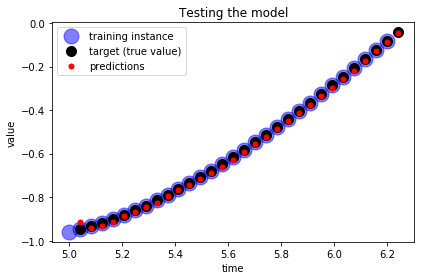

In [19]:
plt.title("Testing the model")
# Training instance
plt.plot(train_inst[:-1], np.sin(train_inst[:-1]), "bo", 
         markersize=15, alpha=0.5, label='training instance')

# Target to predict (True test values ie np.sin(train))
# ie Time Series shifted one step into the future
plt.plot(train_inst[1:], np.sin(train_inst[1:]), "ko", markersize=10, label='target (true value)')

# Model prediction
plt.plot(train_inst[1:],  y_pred[0,:,0], 'r.', markersize=10, label='predictions')
plt.xlabel('time')
plt.ylabel('value')
plt.legend()
plt.tight_layout();

Initially the prediction is way off then it gets better

Temporary session is saved into file

# Generating new Sequence from a seed of Zeroes

In [28]:
with tf.Session() as sess:
    saver.restore(sess, "./TF_RNN_Adam_NoGPU_NoLSTMCell")
    # Seed Zeros
    zero_seq_seed = [0.0 for i in range(num_time_steps)]
    
    for iteration in range(len(ts_data.x_data) - num_time_steps):
        x_batch = np.array(zero_seq_seed[-num_time_steps:]).reshape(1,num_time_steps,1)
        
        y_pred = sess.run(outputs, feed_dict={X: x_batch})
        
        zero_seq_seed.append(y_pred[0,-1,0])

INFO:tensorflow:Restoring parameters from ./TF_RNN_Adam_NoGPU_NoLSTMCell


In [33]:
y_pred[0,-1,0]

0.22844777

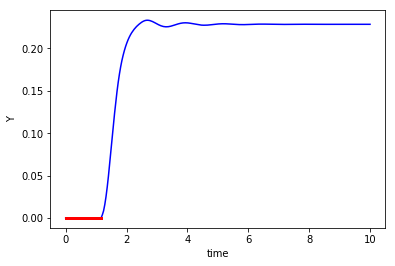

In [34]:
plt.plot(ts_data.x_data, zero_seq_seed, 'b-')
plt.plot(ts_data.x_data[:num_time_steps], zero_seq_seed[:num_time_steps], 'r-', linewidth=3)
plt.xlabel('time')
plt.ylabel('Y');

What the heck is this???

# Generating a sequence from a seed of a Sine Wave

In [36]:
with tf.Session() as sess:
    saver.restore(sess, "./TF_RNN_Adam_NoGPU_NoLSTMCell")
    
    training_instance = list(ts_data.y_true[:30])
    
    for iteration in range(len(training_instance) - num_time_steps):
        x_batch = np.array(training_instance[-num_time_steps:]).reshape(1,num_time_steps,1)
        
        y_pred = sess.run(outputs, feed_dict={X: x_batch})
        
        training_instance.append(y_pred[0,-1,0])
    

INFO:tensorflow:Restoring parameters from ./TF_RNN_Adam_NoGPU_NoLSTMCell


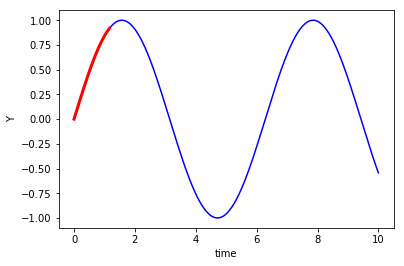

In [36]:
# Plotting
plt.plot(ts_data.x_data, ts_data.y_true, 'b-')
plt.plot(ts_data.x_data[:num_time_steps], training_instance[:num_time_steps], 'r-', linewidth=3)
plt.xlabel('time')
plt.ylabel('Y');

.